# Классификация документов
# Часть 1. Модели "мешка слов"
Выборка разбивается на обучающую и тестовую в соотношении 70/30.

# Оглавление
* Частотные матрицы  
* Взвешенные частотные матрицы  
* Понижение размерности

In [1]:
%env MKL_DYNAMIC=FALSE
%env MKL_NUM_THREADS=8

env: MKL_DYNAMIC=FALSE
env: MKL_NUM_THREADS=8


Необходимые библиотеки

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pickle
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from sklearn.preprocessing import StandardScaler

import gensim
from gensim.models import LsiModel, RpModel

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

pd.set_option('display.max_columns', None)
pd.set_option('display.mpl_style', 'default')
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)

sns.set_style('whitegrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
rc={"lines.linewidth": 1.5})

from pylab import rcParams
rcParams['figure.figsize'] = 15, 5
%matplotlib inline

In [3]:
def pickling_data(name, data):
    out = open(name, 'wb')
    pickle.dump(data, out)
    out.close()
    
def load_data(name):
    pkl_file = open(name, 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

# Частотные матрицы
[Описание]

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import normalize
from sklearn.metrics import f1_score, make_scorer

seed_test = 31415
seed_valid = 27182

matrices = ['unigram_matrix.pkl','bigram_matrix.pkl','trigram_matrix.pkl','collocation_matrix.pkl']
y = np.array(pd.read_csv('category_title_1.csv', usecols=['primary_category']).fillna('math.PR')).flatten()

Распределение целевой переменной


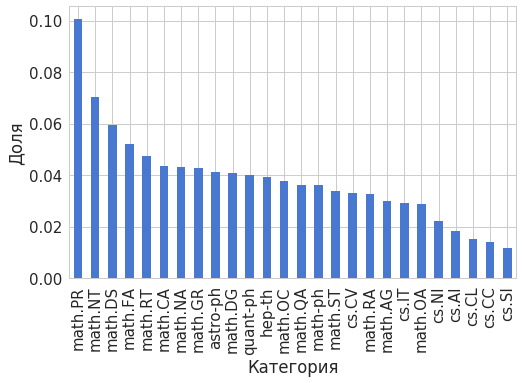

In [7]:
plt.figure(figsize=(8,5))
(pd.Series(y).value_counts() / len(y)).plot(kind='bar')
print("Распределение целевой переменной")
plt.xlabel("Категория")
plt.ylabel("Доля")
plt.show()

In [8]:
def modeling(clf, parameters, X, y, name, normalizing=True, k=5, n_jobs=8, verbose=2):
    '''
    Desciption
    '''
    if normalizing:
        X = normalize(X, norm='l2', axis=1)
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed_test, test_size=0.3)
    print("Train size: %d" % X_train.shape[0])
    print("Test size: %d" % X_test.shape[0])
    
    skf = StratifiedKFold(n_splits=k, random_state=seed_valid)
    f1_scorer = make_scorer(f1_score, average='weighted')
    
    gs = GridSearchCV(clf, parameters, cv=skf, verbose=verbose, n_jobs=n_jobs, scoring=f1_scorer)
    print("Searching best parameters...")
    gs.fit(X_train, y_train)
    pickling_data(name, gs)
    print("Best parameters: %s" % gs.best_params_)
    
    ind = gs.best_index_
    mean_train = gs.cv_results_['mean_train_score'][ind]
    std_train = gs.cv_results_['std_train_score'][ind]
    mean_valid = gs.cv_results_['mean_test_score'][ind]
    std_valid = gs.cv_results_['std_test_score'][ind]
    
    print("Training best model on full train data...")
    clf = gs.best_estimator_
    %time clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score_test = f1_score(y_pred, y_test, average='weighted')
    
    print("Train score: %.3f +/- %.3f" % (mean_train, std_train))
    print("CV score: %.3f +/- %.3f" % (mean_valid, std_valid))
    print("Test score: %.3f\n" % score_test)

## Стахостический градиентный спуск
[Описание]
<img src=http://lijiancheng0614.github.io/scikit-learn/_images/plot_sgd_loss_functions_001.png width="600">

### Логистическая регрессия
[Описание]
<img src=http://www.aprilzephyr.com/images/Essentials/Essentials3.png width="500">  
<center>*Picture from* [this](http://www.aprilzephyr.com) *source*</center>

In [14]:
X_uni = load_data('unigram_matrix.pkl')
X_bi = load_data('bigram_matrix.pkl')
X_tri = load_data('trigram_matrix.pkl')
X_col = load_data('collocation_matrix.pkl')
X_ngram = sparse.hstack((X_uni, X_bi, X_tri))
X_ngram.shape

(163103, 583001)

In [ ]:
clf = SGDClassifier(n_jobs=8, warm_start=True, class_weight='balanced', loss='log', random_state=0, average=True, n_iter=100)
parameters = {'alpha': [10**-i for i in range(1,8)]}

names = ['unigram_matrix','bigram_matrix','trigram_matrix','collocation_matrix','ngram_matrix']
for name, X in zip(names, [X_uni,X_bi,X_tri,X_col,X_ngram]):
    print("Number of features: %d" % X.shape[1])
    %time modeling(clf, parameters, X, y, 'gs_sgd-logistic-' + name, k=3, verbose=1, n_jobs=1)
    print('\n')

Number of features: 54475
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 68.0min finished


Best parameters: {'alpha': 1e-06}
Training best model on full train data...
CPU times: user 33min 38s, sys: 13.7 s, total: 33min 52s
Wall time: 4min 45s
Train score: 0.896 +/- 0.001
CV score: 0.810 +/- 0.001
Test score: 0.820

CPU times: user 9h 10min 1s, sys: 5min 40s, total: 9h 15min 42s
Wall time: 1h 17min 47s


Number of features: 445023
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 331.4min finished


Best parameters: {'alpha': 1e-06}
Training best model on full train data...
CPU times: user 2h 31min 4s, sys: 16 s, total: 2h 31min 20s
Wall time: 20min 26s
Train score: 0.994 +/- 0.000
CV score: 0.819 +/- 0.001
Test score: 0.828

CPU times: user 1d 20h 57min 4s, sys: 6min 16s, total: 1d 21h 3min 21s
Wall time: 6h 12min 57s


Number of features: 83503
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 36.5min finished


Best parameters: {'alpha': 1e-06}
Training best model on full train data...
CPU times: user 20min 57s, sys: 15 s, total: 21min 12s
Wall time: 2min 51s
Train score: 0.989 +/- 0.000
CV score: 0.737 +/- 0.001
Test score: 0.751

CPU times: user 5h 16min 9s, sys: 5min 42s, total: 5h 21min 51s
Wall time: 42min 13s


Number of features: 97006
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 90.5min finished


Best parameters: {'alpha': 1e-06}
Training best model on full train data...
CPU times: user 51min 10s, sys: 14.9 s, total: 51min 24s
Wall time: 6min 58s
Train score: 0.901 +/- 0.001
CV score: 0.807 +/- 0.001
Test score: 0.816

CPU times: user 12h 20min 20s, sys: 5min 52s, total: 12h 26min 12s
Wall time: 1h 43min 38s


Number of features: 583001
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 520.0min finished


Best parameters: {'alpha': 1e-07}
Training best model on full train data...
CPU times: user 4h 42min 15s, sys: 14.5 s, total: 4h 42min 30s
Wall time: 39min 33s
Train score: 0.998 +/- 0.000
CV score: 0.821 +/- 0.001
Test score: 0.837

CPU times: user 2d 23h 58min 33s, sys: 6min 31s, total: 3d 5min 5s
Wall time: 10h 1min 44s




#### Разрежённость коэффициентов модели
[Комментарий]

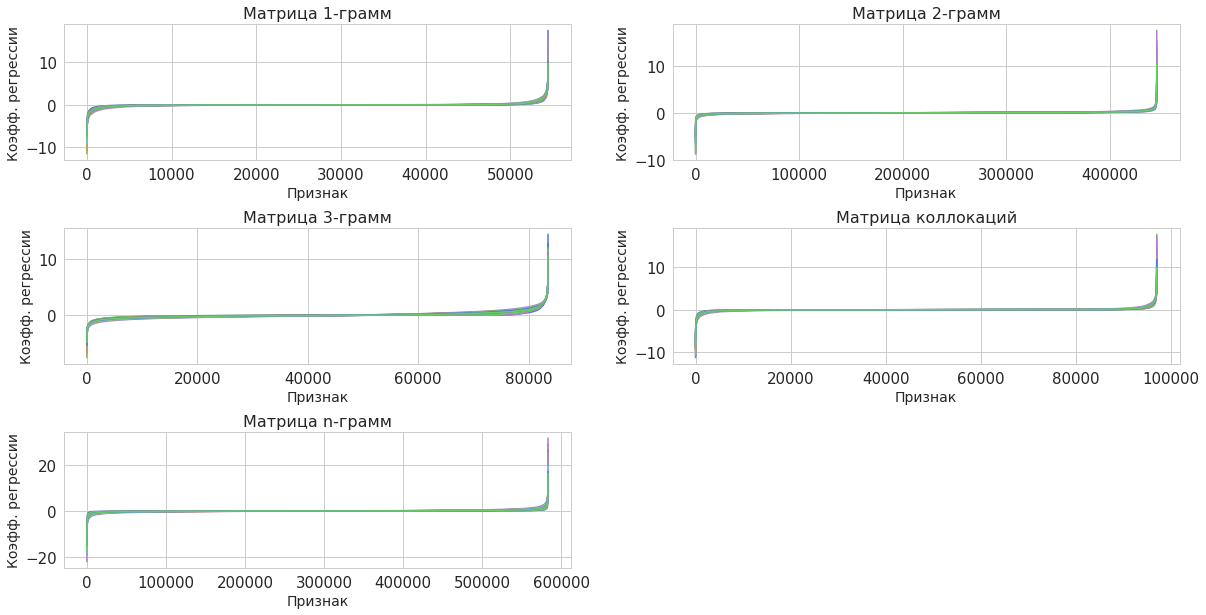

In [51]:
grids = ['gs_sgd-logistic-unigram_matrix.pkl','gs_sgd-logistic-bigram_matrix.pkl','gs_sgd-logistic-trigram_matrix.pkl',\
         'gs_sgd-logistic-collocation_matrix.pkl', 'gs_sgd-logistic-ngram_matrix.pkl']
labels = ['1-грамм','2-грамм','3-грамм','коллокаций','n-грамм']

def plot_coefs(grids, labels, n_row=3):
    '''
    Plotting model coefficients
    '''
    plt.figure(figsize=(20,10))
    for i, grid in enumerate(grids):
        gs = load_data(grid)
        plt.subplot(n_row,2,i+1)
        for j in range(26):
            plt.plot(sorted(gs.best_estimator_.coef_[j]))
        plt.xlabel('Признак', fontsize=14)
        plt.ylabel('Коэфф. регрессии', fontsize=14)
        plt.title('Матрица ' + labels[i], fontsize=16)
    plt.show()
    
plot_coefs(grids, labels)

#### Зависимость качества модели от параметра регуляризации

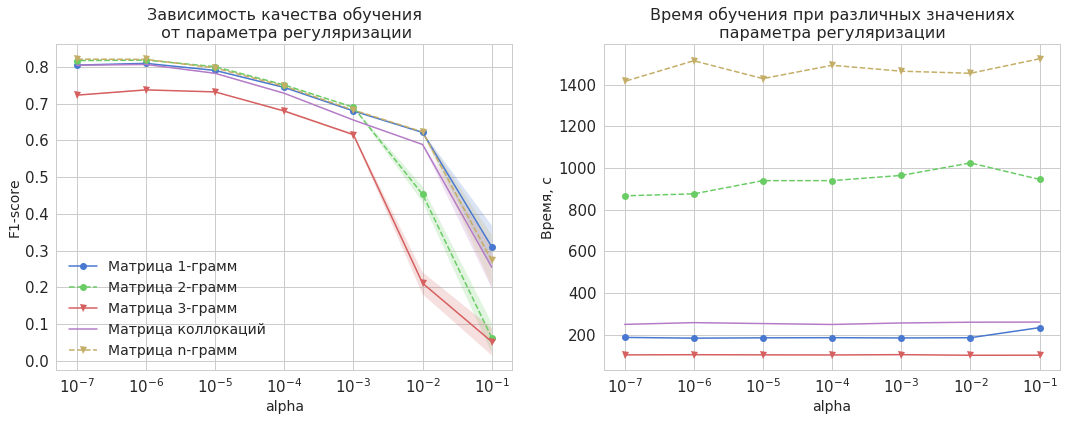

In [4]:
marks = ['o-','o--','v-','-','v--']
grids = ['gs_sgd-logistic-unigram_matrix.pkl','gs_sgd-logistic-bigram_matrix.pkl','gs_sgd-logistic-trigram_matrix.pkl',\
         'gs_sgd-logistic-collocation_matrix.pkl', 'gs_sgd-logistic-ngram_matrix.pkl']
labels = ['1-грамм','2-грамм','3-грамм','коллокаций','n-грамм']
text = ["Зависимость качества обучения\n от параметра регуляризации",\
        "Время обучения при различных значениях\nпараметра регуляризации"]

def plot_cv(grids, labels, marks, title=text, log_scale=True): 
    '''
    Plotting model quality value with different regularization parameters
    '''
    plt.figure(figsize=(18,6))
    
    for i, grid in enumerate(grids):
        gs = load_data(grid)
        params = gs.cv_results_['params']
        p_name = list(params[0])[0]
        vals = [p[p_name] for p in params]
        scores = gs.cv_results_['mean_test_score']
        stds = gs.cv_results_['std_test_score']
        timing = gs.cv_results_['mean_fit_time']
        
        plt.subplot(1,2,1)
        plt.plot(vals, scores, marks[i], label='Матрица '+labels[i])
        plt.fill_between(vals, scores - stds, scores + stds, alpha=0.2, lw=0.1)
        plt.title(text[0], fontsize=16)
        plt.xlabel(p_name, fontsize=14)
        plt.ylabel('F1-score', fontsize=14)
        if log_scale:
            plt.xscale('log')
        plt.legend(fontsize=14)
        
        plt.subplot(1,2,2)
        plt.plot(vals, timing, marks[i], label='Матрица '+labels[i])
        plt.title(text[1], fontsize=16)
        plt.xlabel(p_name, fontsize=14)
        plt.ylabel('Время, с', fontsize=14)
        if log_scale:
            plt.xscale('log')

    plt.show()
    
plot_cv(grids, labels, marks)

### Линейный классификатор с фунцией потерь *modified huber*
[Описание]

In [ ]:
clf = SGDClassifier(n_jobs=8, warm_start=True, class_weight='balanced', loss='modified_huber',\
                    random_state=0, average=True, n_iter=100)
parameters = {'alpha': [10**-i for i in range(1,8)]}

names = ['unigram_matrix','bigram_matrix','trigram_matrix','collocation_matrix','ngram_matrix']
for name, X in zip(names, [X_uni,X_bi,X_tri,X_col,X_ngram]):
    print("Number of features: %d" % X.shape[1])
    %time modeling(clf, parameters, X, y, 'gs_sgd-modhuber-' + name, k=3, verbose=1, n_jobs=1)
    print('\n')

Number of features: 54475
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 51.7min finished


Best parameters: {'alpha': 1e-05}
Training best model on full train data...
CPU times: user 25min 50s, sys: 16.5 s, total: 26min 7s
Wall time: 3min 36s
Train score: 0.903 +/- 0.000
CV score: 0.810 +/- 0.001
Test score: 0.825

CPU times: user 6h 49min 24s, sys: 5min 50s, total: 6h 55min 14s
Wall time: 58min 58s


Number of features: 445023
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 301.2min finished


Best parameters: {'alpha': 1e-05}
Training best model on full train data...
CPU times: user 2h 21min 40s, sys: 13.9 s, total: 2h 21min 54s
Wall time: 19min 16s
Train score: 0.997 +/- 0.000
CV score: 0.821 +/- 0.000
Test score: 0.835

CPU times: user 1d 17h 13min 58s, sys: 6min 6s, total: 1d 17h 20min 5s
Wall time: 5h 40min


Number of features: 83503
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 29.6min finished


Best parameters: {'alpha': 0.0001}
Training best model on full train data...
CPU times: user 16min 20s, sys: 12.7 s, total: 16min 33s
Wall time: 2min 12s
Train score: 0.899 +/- 0.000
CV score: 0.740 +/- 0.001
Test score: 0.750

CPU times: user 4h 10min 52s, sys: 5min 41s, total: 4h 16min 33s
Wall time: 34min 7s


Number of features: 97006
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 73.9min finished


Best parameters: {'alpha': 1e-05}
Training best model on full train data...
CPU times: user 34min 29s, sys: 14.4 s, total: 34min 44s
Wall time: 4min 48s
Train score: 0.911 +/- 0.001
CV score: 0.809 +/- 0.001
Test score: 0.822

CPU times: user 9h 50min 42s, sys: 5min 53s, total: 9h 56min 36s
Wall time: 1h 24min 3s


Number of features: 583001
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 446.8min finished


Best parameters: {'alpha': 1e-05}
Training best model on full train data...
CPU times: user 3h 27min 26s, sys: 15.5 s, total: 3h 27min 41s
Wall time: 29min 13s
Train score: 0.961 +/- 0.000
CV score: 0.824 +/- 0.001
Test score: 0.836

CPU times: user 2d 12h 31min 22s, sys: 6min 22s, total: 2d 12h 37min 44s
Wall time: 8h 25min 57s




**Результаты кросс-валидации**

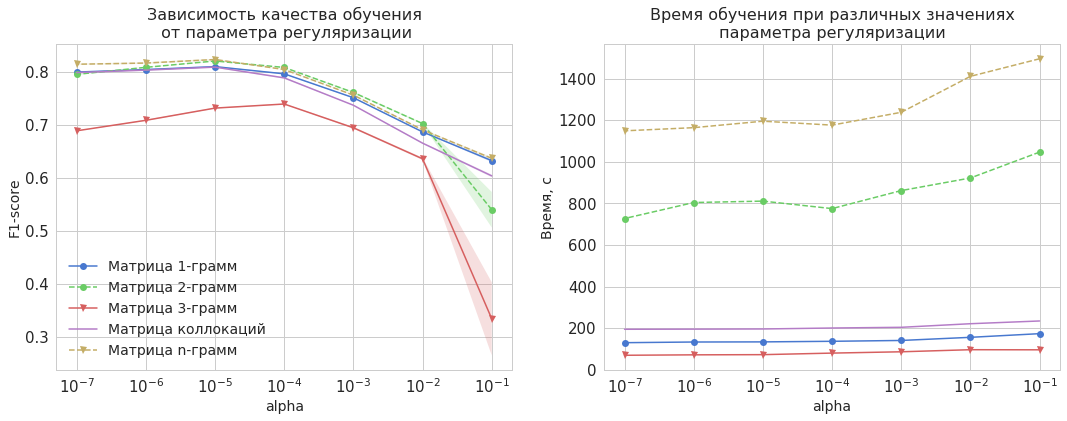

In [52]:
grids = ['gs_sgd-modhuber-unigram_matrix.pkl','gs_sgd-modhuber-bigram_matrix.pkl','gs_sgd-modhuber-trigram_matrix.pkl',\
         'gs_sgd-modhuber-collocation_matrix.pkl', 'gs_sgd-modhuber-ngram_matrix.pkl']

plot_cv(grids, labels, marks)

### Линейная машина опорных векторов
[Описание]
<img src=https://upload.wikimedia.org/wikipedia/commons/2/2a/Svm_max_sep_hyperplane_with_margin.png width="400">  
<center>*Picture from wiki* [page](https://en.wikipedia.org/wiki/Support_vector_machine)</center>  

[Ссылка](http://contrib.scikit-learn.org/lightning/generated/lightning.classification.LinearSVC.html#lightning.classification.LinearSVC) на документацию lightning    
[Ссылка](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) на документацию sklearn\`a  
[Heatmap](http://scikit-learn.org/0.17/auto_examples/svm/plot_rbf_parameters.html)

In [ ]:
clf = SGDClassifier(n_jobs=8, warm_start=True, class_weight='balanced', loss='hinge',\
                    random_state=0, average=True, n_iter=100)
parameters = {'alpha': [10**-i for i in range(1,8)]}

names = ['unigram_matrix','bigram_matrix','trigram_matrix','collocation_matrix','ngram_matrix']
for name, X in zip(names, [X_uni,X_bi,X_tri,X_col,X_ngram]):
    print("Number of features: %d" % X.shape[1])
    %time modeling(clf, parameters, X, y, 'gs_sgd-hinge-' + name, k=3, verbose=1, n_jobs=1)
    print('\n')

Number of features: 54475
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 48.9min finished


Best parameters: {'alpha': 1e-06}
Training best model on full train data...
CPU times: user 25min 32s, sys: 13.7 s, total: 25min 45s
Wall time: 3min 34s
Train score: 0.927 +/- 0.000
CV score: 0.809 +/- 0.001
Test score: 0.825

CPU times: user 6h 29min 7s, sys: 5min 37s, total: 6h 34min 45s
Wall time: 56min 6s


Number of features: 445023
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 259.3min finished


Best parameters: {'alpha': 1e-05}
Training best model on full train data...
CPU times: user 2h 17min 27s, sys: 15 s, total: 2h 17min 43s
Wall time: 18min 38s
Train score: 0.974 +/- 0.000
CV score: 0.819 +/- 0.001
Test score: 0.832

CPU times: user 1d 11h 47min 39s, sys: 6min 6s, total: 1d 11h 53min 46s
Wall time: 4h 56min 44s


Number of features: 83503
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 21.7min finished


Best parameters: {'alpha': 1e-05}
Training best model on full train data...
CPU times: user 11min 47s, sys: 14.9 s, total: 12min 2s
Wall time: 1min 38s
Train score: 0.964 +/- 0.001
CV score: 0.736 +/- 0.001
Test score: 0.753

CPU times: user 2h 58min 15s, sys: 5min 39s, total: 3h 3min 54s
Wall time: 24min 58s


Number of features: 97006
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 59.1min finished


Best parameters: {'alpha': 1e-06}
Training best model on full train data...
CPU times: user 29min 42s, sys: 13.7 s, total: 29min 56s
Wall time: 4min 7s
Train score: 0.940 +/- 0.001
CV score: 0.808 +/- 0.002
Test score: 0.823

CPU times: user 7h 53min 37s, sys: 5min 47s, total: 7h 59min 24s
Wall time: 1h 7min 26s


Number of features: 583001
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 406.3min finished


Best parameters: {'alpha': 1e-06}
Training best model on full train data...
CPU times: user 3h 5min 43s, sys: 14 s, total: 3h 5min 57s
Wall time: 28min 56s
Train score: 0.992 +/- 0.000
CV score: 0.821 +/- 0.001
Test score: 0.839

CPU times: user 2d 5h 1min 16s, sys: 6min 25s, total: 2d 5h 7min 41s
Wall time: 7h 45min 3s




**Результаты кросс-валидации**

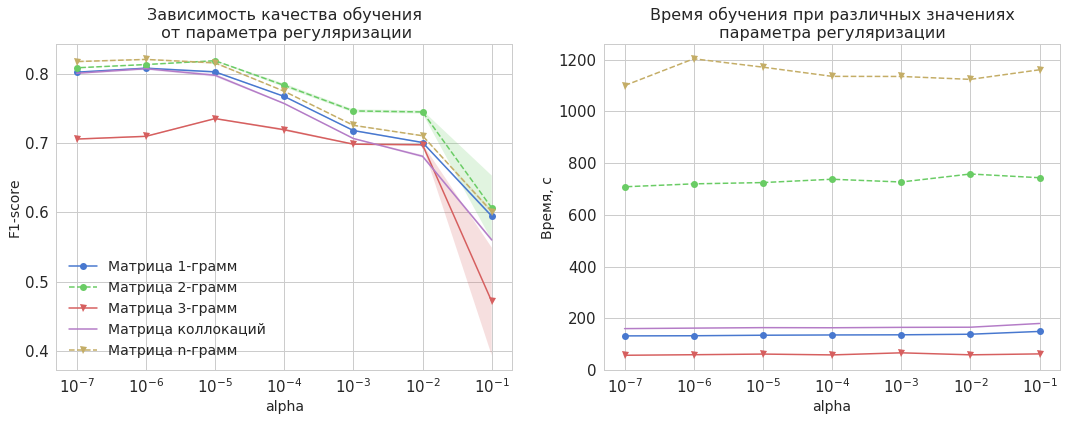

In [53]:
grids = ['gs_sgd-hinge-unigram_matrix.pkl','gs_sgd-hinge-bigram_matrix.pkl','gs_sgd-hinge-trigram_matrix.pkl',\
         'gs_sgd-hinge-collocation_matrix.pkl', 'gs_sgd-hinge-ngram_matrix.pkl']

plot_cv(grids, labels, marks)

### Мультиномиальный наивный Байес

In [64]:
from sklearn.naive_bayes import MultinomialNB

In [67]:
clf = MultinomialNB()
parameters = {'fit_prior': [True, False]}

#X_uni = load_data('unigram_matrix.pkl')
#X_bi = load_data('bigram_matrix.pkl')
#X_tri = load_data('trigram_matrix.pkl')
#X_col = load_data('collocation_matrix.pkl')
#X_ngram = sparse.hstack((X_uni, X_bi, X_tri))

names = ['unigram_matrix','bigram_matrix','trigram_matrix','collocation_matrix','ngram_matrix']
for name, X in zip(names, [X_uni,X_bi,X_tri,X_col,X_ngram]):
    print("Number of features: %d" % X.shape[1])
    %time modeling(clf, parameters, X, y, 'gs_nb-' + name, k=3, verbose=1, n_jobs=1)
    print('\n')

Number of features: 54475
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   52.9s finished


Best parameters: {'fit_prior': False}
Training best model on full train data...
CPU times: user 4.16 s, sys: 0 ns, total: 4.16 s
Wall time: 4.2 s
Train score: 0.541 +/- 0.001
CV score: 0.531 +/- 0.001
Test score: 0.646

CPU times: user 1min, sys: 2.19 s, total: 1min 2s
Wall time: 1min 9s


Number of features: 445023
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.8min finished


Best parameters: {'fit_prior': False}
Training best model on full train data...
CPU times: user 12.7 s, sys: 60 ms, total: 12.8 s
Wall time: 14.8 s
Train score: 0.706 +/- 0.001
CV score: 0.658 +/- 0.001
Test score: 0.711

CPU times: user 3min 4s, sys: 9.25 s, total: 3min 13s
Wall time: 3min 35s


Number of features: 83503
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   27.9s finished


Best parameters: {'fit_prior': False}
Training best model on full train data...
CPU times: user 2.27 s, sys: 4 ms, total: 2.27 s
Wall time: 2.38 s
Train score: 0.786 +/- 0.001
CV score: 0.700 +/- 0.001
Test score: 0.732

CPU times: user 31.8 s, sys: 448 ms, total: 32.2 s
Wall time: 36.3 s


Number of features: 97006
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.0min finished


Best parameters: {'fit_prior': False}
Training best model on full train data...
CPU times: user 4.5 s, sys: 4 ms, total: 4.5 s
Wall time: 4.76 s
Train score: 0.439 +/- 0.002
CV score: 0.428 +/- 0.003
Test score: 0.565

CPU times: user 1min 7s, sys: 3.02 s, total: 1min 10s
Wall time: 1min 18s


Number of features: 583001
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  4.9min finished


Best parameters: {'fit_prior': False}
Training best model on full train data...
CPU times: user 20.1 s, sys: 196 ms, total: 20.3 s
Wall time: 21.9 s
Train score: 0.432 +/- 0.001
CV score: 0.420 +/- 0.002
Test score: 0.522

CPU times: user 8min 6s, sys: 26.5 s, total: 8min 32s
Wall time: 9min 31s




Результаты кросс-валидации

### Лучшая модель 
> **Матрица:** n-граммы  
 **Классификатор:** SVM, alpha=1e-6  
 **Время обучения:** 28min 56s  
 **F1-score:** 0.839

# Взвешенные частотные матрицы
[Описание]

In [7]:
matrices_tfidf = ['unigram_matrix_tfidf','bigram_matrix_tfidf','trigram_matrix_tfidf','collocation_matrix_tfidf']

## Стахостический градиентный спуск
### Логистическая регрессия

In [8]:
clf = SGDClassifier(n_jobs=8, warm_start=True, class_weight='balanced', loss='log', random_state=0, average=True, n_iter=100)
parameters = {'alpha': [10**-i for i in range(3,8)]}

for name in matrices_tfidf:
    X = load_data(name)
    print("Number of features: %d" % X.shape[1])
    %time modeling(clf, parameters, X, y, 'gs_sgd-logistic-' + name, k=3, verbose=1, n_jobs=1)
    print('\n')

Number of features: 54475
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 68.6min finished


Best parameters: {'alpha': 1e-06}
Training best model on full train data...
CPU times: user 45min 47s, sys: 14.1 s, total: 46min 1s
Wall time: 7min 3s
Train score: 0.948 +/- 0.000
CV score: 0.819 +/- 0.001
Test score: 0.832

CPU times: user 8h 45min 5s, sys: 4min 18s, total: 8h 49min 23s
Wall time: 1h 22min 46s


Number of features: 445023
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 227.5min finished


Best parameters: {'alpha': 1e-06}
Training best model on full train data...
CPU times: user 2h 47min 34s, sys: 15.6 s, total: 2h 47min 49s
Wall time: 23min 7s
Train score: 0.997 +/- 0.000
CV score: 0.826 +/- 0.001
Test score: 0.835

CPU times: user 1d 7h 55min 57s, sys: 4min 40s, total: 1d 8h 38s
Wall time: 4h 33min 34s


Number of features: 83503
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 24.7min finished


Best parameters: {'alpha': 1e-05}
Training best model on full train data...
CPU times: user 17min 32s, sys: 15.3 s, total: 17min 47s
Wall time: 2min 18s
Train score: 0.887 +/- 0.001
CV score: 0.744 +/- 0.000
Test score: 0.750

CPU times: user 3h 29min 49s, sys: 4min 25s, total: 3h 34min 15s
Wall time: 29min 20s


Number of features: 97006
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 80.0min finished


Best parameters: {'alpha': 1e-06}
Training best model on full train data...
CPU times: user 59min 21s, sys: 15.2 s, total: 59min 36s
Wall time: 8min 4s
Train score: 0.964 +/- 0.000
CV score: 0.820 +/- 0.002
Test score: 0.833

CPU times: user 11h 38min 45s, sys: 4min 30s, total: 11h 43min 15s
Wall time: 1h 35min 59s




**Конкатенация матриц 1-2-3-грамм**

In [10]:
X_uni = load_data('unigram_matrix_tfidf')
X_bi = load_data('bigram_matrix_tfidf')
X_tri = load_data('trigram_matrix_tfidf')
X_ngram = sparse.hstack((X_uni, X_bi, X_tri))
X_ngram.shape

(163103, 583001)

In [11]:
print("Number of features: %d" % X_ngram.shape[1])
%time modeling(clf, parameters, X_ngram, y, 'gs_sgd-logistic-' + name, k=3, verbose=1, n_jobs=1)

Number of features: 583001
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 471.3min finished


Best parameters: {'alpha': 1e-07}
Training best model on full train data...
CPU times: user 4h 11min 37s, sys: 39.2 s, total: 4h 12min 16s
Wall time: 40min 13s
Train score: 1.000 +/- 0.000
CV score: 0.832 +/- 0.001
Test score: 0.846

CPU times: user 2d 8h 56min 18s, sys: 9min 10s, total: 2d 9h 5min 28s
Wall time: 9h 16min 10s


**Результаты кросс-валидации**

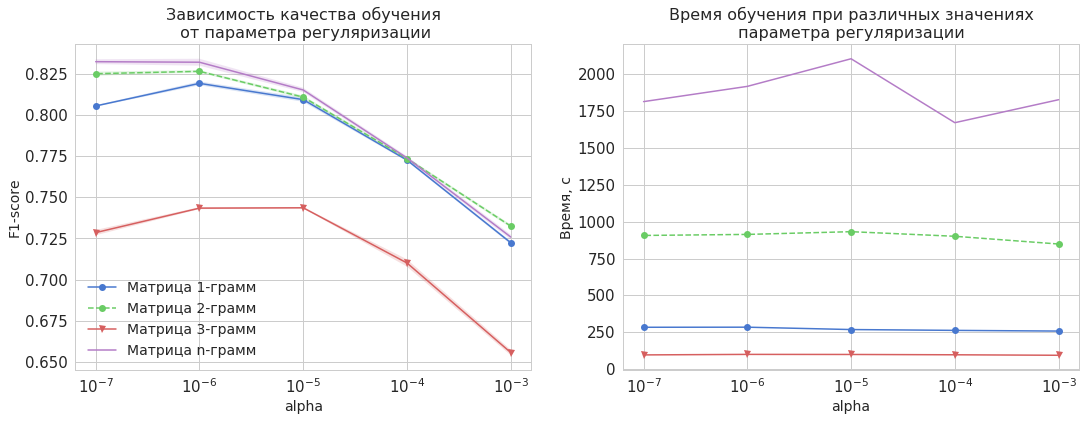

In [55]:
grids = ['gs_sgd-logistic-unigram_matrix_tfidf.pkl','gs_sgd-logistic-bigram_matrix_tfidf.pkl',\
         'gs_sgd-logistic-trigram_matrix_tfidf.pkl', 'gs_sgd-logistic-ngram_matrix_tfidf.pkl']
labels = ['1-грамм','2-грамм','3-грамм','n-грамм']

plot_cv(grids, labels, marks)

### Линейный классификатор с функцией потерь *modified huber*

In [12]:
clf = SGDClassifier(n_jobs=8, warm_start=True, class_weight='balanced',\
                    loss='modified_huber', random_state=0, average=True, n_iter=100)
parameters = {'alpha': [10**-i for i in range(3,8)]}

for name in matrices_tfidf:
    X = load_data(name)
    print("Number of features: %d" % X.shape[1])
    %time modeling(clf, parameters, X, y, 'gs_sgd-modhuber-' + name, k=3, verbose=1, n_jobs=1)
    print('\n')

Number of features: 54475
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 48.5min finished


Best parameters: {'alpha': 1e-05}
Training best model on full train data...
CPU times: user 33min 8s, sys: 36.1 s, total: 33min 44s
Wall time: 4min 45s
Train score: 0.956 +/- 0.000
CV score: 0.819 +/- 0.001
Test score: 0.834

CPU times: user 6h 33min 54s, sys: 9min 18s, total: 6h 43min 12s
Wall time: 58min 4s


Number of features: 445023
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 240.8min finished


Best parameters: {'alpha': 1e-05}
Training best model on full train data...
CPU times: user 2h 17min 20s, sys: 44.1 s, total: 2h 18min 4s
Wall time: 18min 46s
Train score: 0.999 +/- 0.000
CV score: 0.827 +/- 0.001
Test score: 0.841

CPU times: user 1d 8h 47min 1s, sys: 11min 8s, total: 1d 8h 58min 9s
Wall time: 4h 39min 4s


Number of features: 83503
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 22.3min finished


Best parameters: {'alpha': 0.0001}
Training best model on full train data...
CPU times: user 16min 3s, sys: 32.6 s, total: 16min 36s
Wall time: 2min 12s
Train score: 0.911 +/- 0.001
CV score: 0.747 +/- 0.001
Test score: 0.758

CPU times: user 3h 6min 51s, sys: 9min 53s, total: 3h 16min 45s
Wall time: 26min 48s


Number of features: 97006
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 63.9min finished


Best parameters: {'alpha': 1e-05}
Training best model on full train data...
CPU times: user 42min 2s, sys: 29.1 s, total: 42min 31s
Wall time: 5min 56s
Train score: 0.972 +/- 0.000
CV score: 0.820 +/- 0.002
Test score: 0.835

CPU times: user 8h 36min 38s, sys: 9min 41s, total: 8h 46min 19s
Wall time: 1h 16min




Обучение модели на матрице n-грамм

In [16]:
print("Number of features: %d" % X_ngram.shape[1])
%time modeling(clf, parameters, X_ngram, y, 'gs_sgd-modhuber-ngram_tfidf', k=3, verbose=1, n_jobs=1)

Number of features: 583001
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 419.9min finished


Best parameters: {'alpha': 1e-05}
Training best model on full train data...
CPU times: user 3h 37min 58s, sys: 35.5 s, total: 3h 38min 34s
Wall time: 30min 35s
Train score: 0.998 +/- 0.000
CV score: 0.835 +/- 0.002
Test score: 0.848

CPU times: user 2d 7h 23min 32s, sys: 11min 1s, total: 2d 7h 34min 33s
Wall time: 8h 4min 52s


**Результаты кросс-валидации**

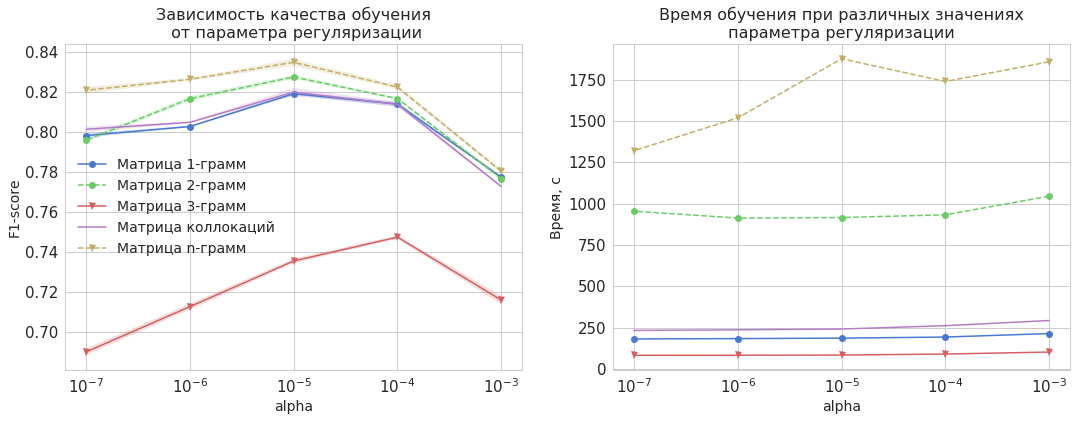

In [57]:
grids = ['gs_sgd-modhuber-unigram_matrix_tfidf.pkl','gs_sgd-modhuber-bigram_matrix_tfidf.pkl','gs_sgd-modhuber-trigram_matrix_tfidf.pkl',\
         'gs_sgd-modhuber-collocation_matrix_tfidf.pkl', 'gs_sgd-modhuber-ngram_tfidf.pkl']
labels = ['1-грамм','2-грамм','3-грамм','коллокаций','n-грамм']

plot_cv(grids, labels, marks)

### Линейная машина опорных векторов

In [13]:
clf = SGDClassifier(n_jobs=8, warm_start=True, class_weight='balanced',\
                    loss='hinge', random_state=0, average=True, n_iter=100)
parameters = {'alpha': [10**-i for i in range(3,8)]}

for name in matrices_tfidf:
    X = load_data(name)
    print("Number of features: %d" % X.shape[1])
    %time modeling(clf, parameters, X, y, 'gs_sgd-hinge-' + name, k=3, verbose=1, n_jobs=1)
    print('\n')

Number of features: 54475
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 44.8min finished


Best parameters: {'alpha': 1e-05}
Training best model on full train data...
CPU times: user 32min 11s, sys: 33.4 s, total: 32min 44s
Wall time: 4min 34s
Train score: 0.910 +/- 0.000
CV score: 0.818 +/- 0.002
Test score: 0.830

CPU times: user 6h 15min 17s, sys: 9min 25s, total: 6h 24min 43s
Wall time: 53min 53s


Number of features: 445023
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 261.9min finished


Best parameters: {'alpha': 1e-05}
Training best model on full train data...
CPU times: user 2h 14min 17s, sys: 34.2 s, total: 2h 14min 51s
Wall time: 18min 22s
Train score: 0.985 +/- 0.000
CV score: 0.827 +/- 0.000
Test score: 0.838

CPU times: user 1d 11h 48min 16s, sys: 10min 44s, total: 1d 11h 59min
Wall time: 4h 59min


Number of features: 83503
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 21.4min finished


Best parameters: {'alpha': 1e-05}
Training best model on full train data...
CPU times: user 14min 17s, sys: 35.4 s, total: 14min 52s
Wall time: 2min
Train score: 0.971 +/- 0.000
CV score: 0.740 +/- 0.001
Test score: 0.757

CPU times: user 2h 56min 15s, sys: 9min 44s, total: 3h 5min 59s
Wall time: 25min 35s


Number of features: 97006
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 57.4min finished


Best parameters: {'alpha': 1e-05}
Training best model on full train data...
CPU times: user 41min 3s, sys: 28.7 s, total: 41min 31s
Wall time: 5min 46s
Train score: 0.926 +/- 0.000
CV score: 0.819 +/- 0.001
Test score: 0.832

CPU times: user 8h 3min 56s, sys: 9min 55s, total: 8h 13min 51s
Wall time: 1h 9min 8s




Обучение модели на матрице n-грамм

In [14]:
print("Number of features: %d" % X_ngram.shape[1])
%time modeling(clf, parameters, X_ngram, y, 'gs_sgd-hinge-ngram_tfidf', k=3, verbose=1, n_jobs=1)

Number of features: 583001
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 396.8min finished


Best parameters: {'alpha': 1e-05}
Training best model on full train data...
CPU times: user 3h 33min 45s, sys: 36.7 s, total: 3h 34min 22s
Wall time: 29min 48s
Train score: 0.978 +/- 0.000
CV score: 0.833 +/- 0.002
Test score: 0.843

CPU times: user 1d 22h 27min 23s, sys: 10min 32s, total: 1d 22h 37min 56s
Wall time: 7h 37min 35s


#### Результаты кросс-валидации

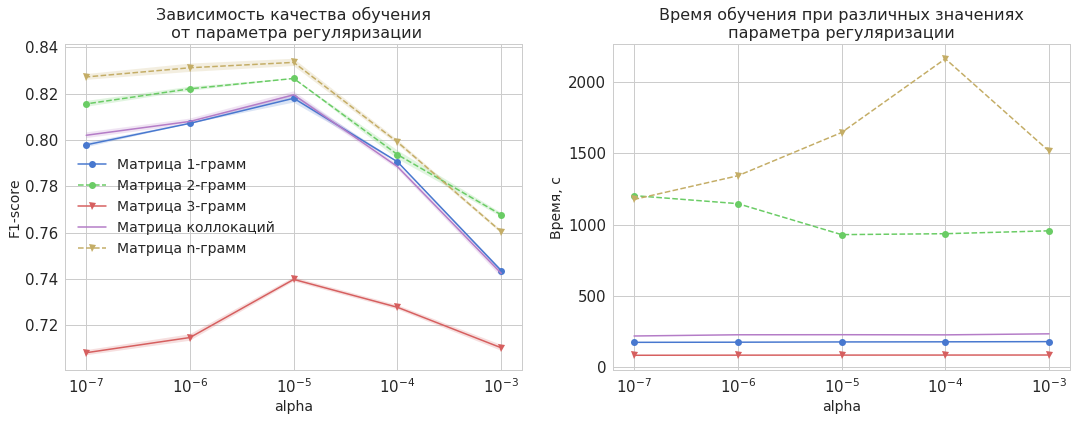

In [58]:
grids = ['gs_sgd-hinge-unigram_matrix_tfidf.pkl','gs_sgd-hinge-bigram_matrix_tfidf.pkl',\
         'gs_sgd-hinge-trigram_matrix_tfidf.pkl','gs_sgd-hinge-collocation_matrix_tfidf.pkl',\
         'gs_sgd-hinge-ngram_tfidf.pkl']

plot_cv(grids, labels, marks)

### Лучшая модель 
> **Матрица:** n-граммы  
 **Классификатор:** логистическая регрессия, alpha=1e-07  
 **Время обучения:** 40min 13s  
 **F1-score:** 0.846

# Методы понижения размерности

## 1. Латентно-семантический анализ

In [9]:
path_to_models = '/home/kulesh271828/arxiv/models/dim_reduction/'

models = ['unigram.lsa','bigram.lsa','trigram.lsa','ngram.lsa','collocation.lsa']

### Логистическая регрессия

In [20]:
clf = SGDClassifier(n_jobs=8, warm_start=True, class_weight='balanced', loss='log', random_state=0, average=True, n_iter=100)
parameters = {'alpha': [10**-i for i in range(4,9)]}

for model in models:
    lsa = LsiModel.load(path_to_models + model)
    X = lsa.projection.u
    print("Number of features: %d" % X.shape[1])
    %time modeling(clf, parameters, X, y, 'gs_sgd-logistic-' + model, k=3, verbose=1, n_jobs=1)
    print('\n')

Number of features: 1000
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 52.6min finished


Best parameters: {'alpha': 1e-06}
Training best model on full train data...
CPU times: user 36min 44s, sys: 24 ms, total: 36min 44s
Wall time: 5min 16s
Train score: 0.837 +/- 0.000
CV score: 0.793 +/- 0.001
Test score: 0.801

CPU times: user 7h 17min 58s, sys: 9.36 s, total: 7h 18min 8s
Wall time: 1h 3min 11s


Number of features: 1000
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 52.2min finished


Best parameters: {'alpha': 1e-07}
Training best model on full train data...
CPU times: user 36min 38s, sys: 44 ms, total: 36min 39s
Wall time: 5min 16s
Train score: 0.834 +/- 0.001
CV score: 0.793 +/- 0.000
Test score: 0.803

CPU times: user 7h 15min 30s, sys: 10.2 s, total: 7h 15min 40s
Wall time: 1h 2min 48s


Number of features: 1000
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 52.4min finished


Best parameters: {'alpha': 1e-07}
Training best model on full train data...
CPU times: user 36min 38s, sys: 40 ms, total: 36min 38s
Wall time: 5min 14s
Train score: 0.761 +/- 0.001
CV score: 0.715 +/- 0.001
Test score: 0.725

CPU times: user 7h 16min 41s, sys: 9.87 s, total: 7h 16min 51s
Wall time: 1h 3min 1s


Number of features: 1000
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 52.3min finished


Best parameters: {'alpha': 1e-06}
Training best model on full train data...
CPU times: user 36min 37s, sys: 60 ms, total: 36min 37s
Wall time: 5min 14s
Train score: 0.845 +/- 0.001
CV score: 0.804 +/- 0.002
Test score: 0.811

CPU times: user 7h 16min 9s, sys: 10.1 s, total: 7h 16min 20s
Wall time: 1h 2min 50s


Number of features: 1000
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 53.4min finished


Best parameters: {'alpha': 1e-06}
Training best model on full train data...
CPU times: user 36min 41s, sys: 40 ms, total: 36min 41s
Wall time: 5min 15s
Train score: 0.835 +/- 0.000
CV score: 0.789 +/- 0.001
Test score: 0.797

CPU times: user 7h 23min 6s, sys: 12.7 s, total: 7h 23min 19s
Wall time: 1h 4min 2s




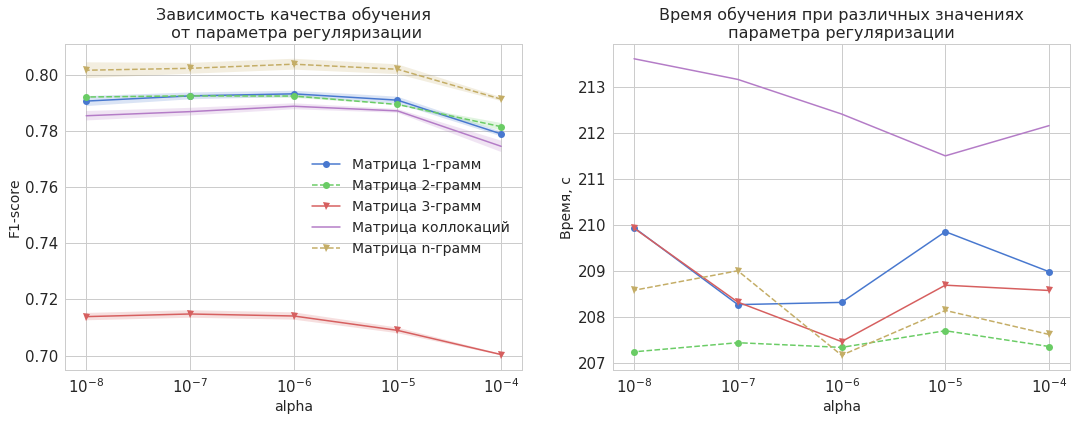

In [59]:
grids = ['gs_sgd-logistic-unigram.lsa.pkl','gs_sgd-logistic-bigram.lsa.pkl',\
         'gs_sgd-logistic-trigram.lsa.pkl','gs_sgd-logistic-collocation.lsa.pkl',\
         'gs_sgd-logistic-ngram.lsa.pkl']

plot_cv(grids, labels, marks)

### Линейная машина опорных векторов

In [21]:
clf = SGDClassifier(n_jobs=8, warm_start=True, class_weight='balanced', loss='hinge', random_state=0, average=True, n_iter=100)
parameters = {'alpha': [10**-i for i in range(4,9)]}

for model in models:
    lsa = LsiModel.load(path_to_models + model)
    X = lsa.projection.u
    print("Number of features: %d" % X.shape[1])
    %time modeling(clf, parameters, X, y, 'gs_sgd-hinge-' + model, k=3, verbose=1, n_jobs=1)
    print('\n')

Number of features: 1000
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 34.2min finished


Best parameters: {'alpha': 1e-06}
Training best model on full train data...
CPU times: user 22min 52s, sys: 20 ms, total: 22min 52s
Wall time: 3min 18s
Train score: 0.840 +/- 0.000
CV score: 0.793 +/- 0.002
Test score: 0.804

CPU times: user 4h 39min 35s, sys: 9.88 s, total: 4h 39min 44s
Wall time: 40min 53s


Number of features: 1000
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 34.2min finished


Best parameters: {'alpha': 1e-07}
Training best model on full train data...
CPU times: user 22min 57s, sys: 4 ms, total: 22min 57s
Wall time: 3min 18s
Train score: 0.834 +/- 0.001
CV score: 0.793 +/- 0.001
Test score: 0.803

CPU times: user 4h 39min 29s, sys: 10.3 s, total: 4h 39min 39s
Wall time: 40min 54s


Number of features: 1000
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 34.7min finished


Best parameters: {'alpha': 1e-07}
Training best model on full train data...
CPU times: user 22min 46s, sys: 40 ms, total: 22min 46s
Wall time: 3min 42s
Train score: 0.761 +/- 0.001
CV score: 0.715 +/- 0.001
Test score: 0.726

CPU times: user 4h 38min 59s, sys: 9.96 s, total: 4h 39min 9s
Wall time: 42min 10s


Number of features: 1000
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 38.1min finished


Best parameters: {'alpha': 1e-07}
Training best model on full train data...
CPU times: user 22min 45s, sys: 24 ms, total: 22min 45s
Wall time: 3min 44s
Train score: 0.852 +/- 0.001
CV score: 0.803 +/- 0.002
Test score: 0.815

CPU times: user 4h 35min 4s, sys: 11.1 s, total: 4h 35min 15s
Wall time: 45min 38s


Number of features: 1000
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 37.4min finished


Best parameters: {'alpha': 1e-06}
Training best model on full train data...
CPU times: user 23min 7s, sys: 24 ms, total: 23min 7s
Wall time: 3min 20s
Train score: 0.837 +/- 0.000
CV score: 0.788 +/- 0.001
Test score: 0.801

CPU times: user 4h 36min 11s, sys: 10.4 s, total: 4h 36min 21s
Wall time: 44min 12s




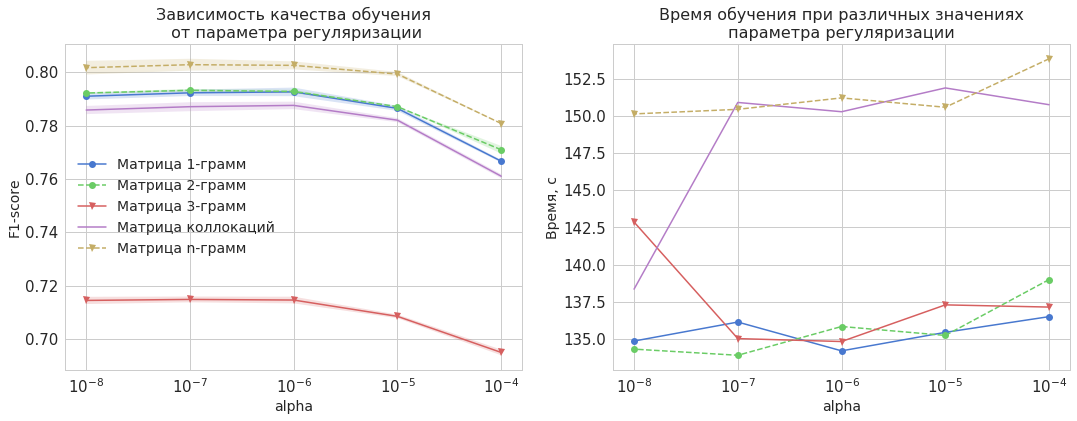

In [60]:
grids = ['gs_sgd-hinge-unigram.lsa.pkl','gs_sgd-hinge-bigram.lsa.pkl',\
         'gs_sgd-hinge-trigram.lsa.pkl','gs_sgd-hinge-collocation.lsa.pkl',\
         'gs_sgd-hinge-ngram.lsa.pkl']

plot_cv(grids, labels, marks)

### Линейный классификатор с функцией потерь *modified huber*

In [22]:
clf = SGDClassifier(n_jobs=8, warm_start=True, class_weight='balanced', loss='modified_huber',\
                    random_state=0, average=True, n_iter=100)
parameters = {'alpha': [10**-i for i in range(4,9)]}

for model in models:
    lsa = LsiModel.load(path_to_models + model)
    X = lsa.projection.u
    print("Number of features: %d" % X.shape[1])
    %time modeling(clf, parameters, X, y, 'gs_sgd-modhuber-' + model, k=3, verbose=1, n_jobs=1)
    print('\n')

Number of features: 1000
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 34.4min finished


Best parameters: {'alpha': 1e-05}
Training best model on full train data...
CPU times: user 23min 59s, sys: 12 ms, total: 23min 59s
Wall time: 3min 25s
Train score: 0.834 +/- 0.000
CV score: 0.794 +/- 0.001
Test score: 0.804

CPU times: user 4h 43min 58s, sys: 10.3 s, total: 4h 44min 8s
Wall time: 41min 23s


Number of features: 1000
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 34.6min finished


Best parameters: {'alpha': 1e-05}
Training best model on full train data...
CPU times: user 23min 57s, sys: 20 ms, total: 23min 57s
Wall time: 3min 28s
Train score: 0.824 +/- 0.001
CV score: 0.793 +/- 0.000
Test score: 0.801

CPU times: user 4h 44min 49s, sys: 10.6 s, total: 4h 45min
Wall time: 41min 35s


Number of features: 1000
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 34.9min finished


Best parameters: {'alpha': 1e-08}
Training best model on full train data...
CPU times: user 23min 14s, sys: 52 ms, total: 23min 14s
Wall time: 3min 21s
Train score: 0.763 +/- 0.001
CV score: 0.715 +/- 0.001
Test score: 0.726

CPU times: user 4h 45min 57s, sys: 9.98 s, total: 4h 46min 7s
Wall time: 41min 43s


Number of features: 1000
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 34.7min finished


Best parameters: {'alpha': 1e-05}
Training best model on full train data...
CPU times: user 23min 57s, sys: 56 ms, total: 23min 57s
Wall time: 3min 28s
Train score: 0.843 +/- 0.001
CV score: 0.804 +/- 0.002
Test score: 0.813

CPU times: user 4h 44min 59s, sys: 9.9 s, total: 4h 45min 9s
Wall time: 41min 45s


Number of features: 1000
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 35.4min finished


Best parameters: {'alpha': 1e-05}
Training best model on full train data...
CPU times: user 23min 54s, sys: 24 ms, total: 23min 54s
Wall time: 3min 53s
Train score: 0.832 +/- 0.000
CV score: 0.789 +/- 0.001
Test score: 0.800

CPU times: user 4h 42min 21s, sys: 10.3 s, total: 4h 42min 31s
Wall time: 43min 18s




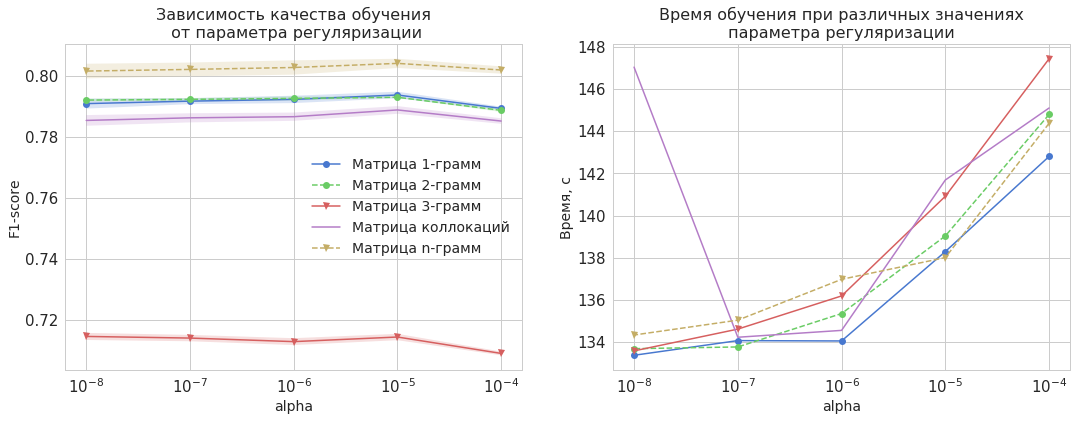

In [61]:
grids = ['gs_sgd-modhuber-unigram.lsa.pkl','gs_sgd-modhuber-bigram.lsa.pkl',\
         'gs_sgd-modhuber-trigram.lsa.pkl','gs_sgd-modhuber-collocation.lsa.pkl',\
         'gs_sgd-modhuber-ngram.lsa.pkl']

plot_cv(grids, labels, marks)

### Градиентный бустинг
[Complete Guide to Parameter Tuning in XGBoost (with codes in Python)](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

In [35]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

In [39]:
categories = list(set(y))

In [41]:
enc = LabelEncoder()
enc.fit(categories)
y_int = enc.transform(y)

### K-ближайших соседей
[Описание]
![knn](https://upload.wikimedia.org/wikipedia/commons/e/e7/KnnClassification.svg)

In [10]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_jobs=8, algorithm='ball_tree')
parameters = {'n_neighbors': [25,50,100],
              'weights': ['distance'],
              'leaf_size': [30,60,120]}

In [12]:
lsa = LsiModel.load(path_to_models + 'ngram.lsa')
X = lsa.projection.u
print("Number of features: %d" % X.shape[1])
%time modeling(knn, parameters, X, y, 'gs_knn-' + 'ngram.lsa', k=2, normalizing=False, n_jobs=1, verbose=2)

Number of features: 1000
Train size: 114172
Test size: 48931
Searching best parameters...
Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV] leaf_size=30, n_neighbors=25, weights=distance ..................
[CV] ... leaf_size=30, n_neighbors=25, weights=distance, total=45.7min
[CV] leaf_size=30, n_neighbors=25, weights=distance ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 78.0min remaining:    0.0s


[CV] ... leaf_size=30, n_neighbors=25, weights=distance, total=29.5min
[CV] leaf_size=30, n_neighbors=50, weights=distance ..................
[CV] ... leaf_size=30, n_neighbors=50, weights=distance, total=29.8min
[CV] leaf_size=30, n_neighbors=50, weights=distance ..................
[CV] ... leaf_size=30, n_neighbors=50, weights=distance, total=28.8min
[CV] leaf_size=30, n_neighbors=100, weights=distance .................
[CV] .. leaf_size=30, n_neighbors=100, weights=distance, total=28.6min
[CV] leaf_size=30, n_neighbors=100, weights=distance .................
[CV] .. leaf_size=30, n_neighbors=100, weights=distance, total=28.3min
[CV] leaf_size=60, n_neighbors=25, weights=distance ..................
[CV] ... leaf_size=60, n_neighbors=25, weights=distance, total=29.1min
[CV] leaf_size=60, n_neighbors=25, weights=distance ..................
[CV] ... leaf_size=60, n_neighbors=25, weights=distance, total=28.4min
[CV] leaf_size=60, n_neighbors=50, weights=distance ..................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 891.8min finished


Best parameters: {'leaf_size': 30, 'n_neighbors': 100, 'weights': 'distance'}
Training best model on full train data...
CPU times: user 23.5 s, sys: 28 ms, total: 23.5 s
Wall time: 25.7 s
Train score: 1.000 +/- 0.000
CV score: 0.606 +/- 0.007
Test score: 0.588

CPU times: user 2d 22h 46min 49s, sys: 1min 19s, total: 2d 22h 48min 8s
Wall time: 15h 28min 3s


### Лучшая модель 
> **Матрица:** n-граммы  
 **Классификатор:** SVM, alpha=1e-07  
 **Время обучения:** 3min 44s  
 **F1-score:** 0.815

### Варьирование кол-ва компонент
[Описание]

In [25]:
#clf = SGDClassifier(n_jobs=8, warm_start=True, class_weight='balanced', loss='hinge',\
#                    alpha=1e-07, random_state=0, average=True, n_iter=100)

lsa = LsiModel.load(path_to_models + 'ngram.lsa')
X = lsa.projection.u
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed_test, test_size=0.3)

In [39]:
vals = [50, 100, 200, 400, 1000]
scores = []

for i in vals:
    print("Number of features: %d" % i)
    clf = SGDClassifier(n_jobs=8, warm_start=True, class_weight='balanced', loss='hinge',\
                    alpha=1e-07, random_state=0, average=True, n_iter=100)
    clf.fit(X_train[:,:i], y_train)
    y_pred = clf.predict(X_test[:,:i])
    score_test = f1_score(y_pred, y_test, average='weighted')
    scores.append(score_test)
    print("Test score: %.3f" % score_test)
    print('\n')

Number of features: 50
Test score: 0.730


Number of features: 100
Test score: 0.757


Number of features: 200
Test score: 0.774


Number of features: 400
Test score: 0.791


Number of features: 1000
Test score: 0.806




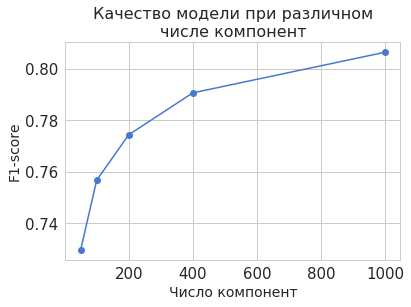

In [62]:
plt.plot(vals, scores, 'o-')
plt.title("Качество модели при различном\nчисле компонент", size=16)
plt.xlabel("Число компонент", size=14)
plt.ylabel("F1-score", size=14)
plt.show()

[Вывод]

## 2. Случайные проекции

In [13]:
rp_models = ['unigram.rp','bigram.rp','trigram.rp','ngram.rp','collocation.rp']

### Логистическая регрессия

In [ ]:
clf = SGDClassifier(n_jobs=8, warm_start=True, class_weight='balanced', loss='log', random_state=0, average=True, n_iter=100)
parameters = {'alpha': [10**-i for i in range(4,9)]}

for model in rp_models:
    rp = RpModel.load(path_to_models + model)
    X = rp.projection.transpose()
    print("Number of features: %d" % X.shape[1])
    %time modeling(clf, parameters, X, y, 'gs_sgd-logistic-' + model, k=3, verbose=1, n_jobs=1)
    print('\n')

#### Шум
**Test score**: 0.092

## Источники

1. sklearn.linear_model.LogisticRegression [Документация](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)  
2. [lightning](http://contrib.scikit-learn.org/lightning/references.html) -- library for large-scale linear classification, regression and ranking in Python.  
- Plotting Learning Curves [Code](http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html)  
- Plotting Validation Curves [Code](http://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html)